Further studies on Spherical Harmonic Domain (SHD) filters
===

These filters are axisymmetric and hence expressed as a modal weighting / SH order tapering window.

Chris Hold

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import spaudiopy as spa

%config InlineBackend.figure_formats = ['png']
%matplotlib inline

In [2]:
N_sph = 5

steer_azi = 0
steer_zen = np.pi/2

In [3]:
Y_steer = spa.sph.sh_matrix(N_sph, steer_azi, steer_zen)

In [4]:
def polar_comparison(w_n, steer_azi=0, title=None, **kwargs):
    theta = np.linspace(0, 2 * np.pi, 720, endpoint=True)
    dirac_tapered = spa.sph.bandlimited_dirac(N_sph, theta - steer_azi, w_n=w_n)
    dirac = spa.sph.bandlimited_dirac(N_sph, theta - steer_azi, w_n=spa.sph.unity_gain(np.ones_like(w_n)))
    
    fig = plt.figure()
    ax = fig.add_subplot(projection='polar')
    spa.plot.polar(theta, dirac_tapered, ax=ax, **kwargs)
    ax.set_prop_cycle(None)
    spa.plot.polar(theta, dirac, ax=ax, **kwargs)
    for line, ls in zip(ax.get_lines(), ['-', '-', ':', ':']):
        line.set_linestyle(ls)
    ax.legend(['$+$', '$-$'], loc='lower right')
    plt.title(title)

In [5]:
def plot_sph_filter(w_n, steer_azi=0, title=None):
    azi_p = np.linspace(0, 2 * np.pi, 720, endpoint=True)
    dirac_tapered = spa.sph.bandlimited_dirac(N_sph, azi_p - steer_azi, w_n=w_n)

    fig = plt.figure()
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.stem(w_n)
    ax1.grid(1)
    ax1.set_title("Filter Coefficients")
    ax1.set_xlabel("Order")
    ax2 = fig.add_subplot(1, 2, 2, projection='polar')
    spa.plot.polar(azi_p, dirac_tapered, ax=ax2)
    ax2.set_title("Cross-Section")
    fig.suptitle(title)

A few implementations according to : 
Devaraju, B. (2015). Understanding filtering on the sphere.

First, the so called 'Boxcar' window, which is only the truncation to $N=5$.

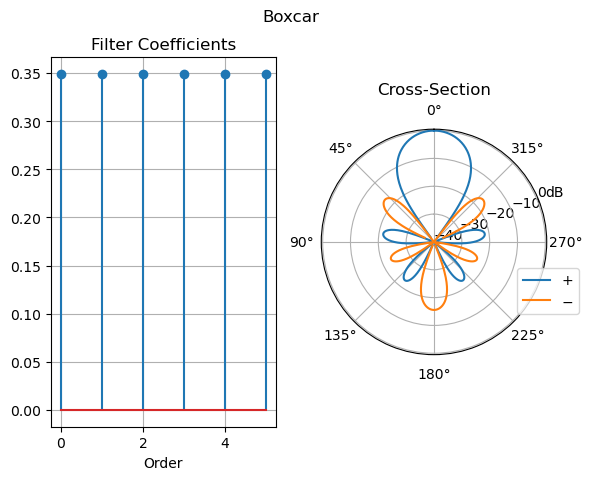

In [6]:
#Boxcar
w_n = np.ones(N_sph + 1)
w_n = spa.sph.unity_gain(w_n)

plot_sph_filter(w_n, title="Boxcar")

The cardioid pattern is widely understood and studied, and below is a higher-order version.
It does not exhibit any negative sidelobe.
The pattern is quite broad, and higher orders are significantly attenuated.

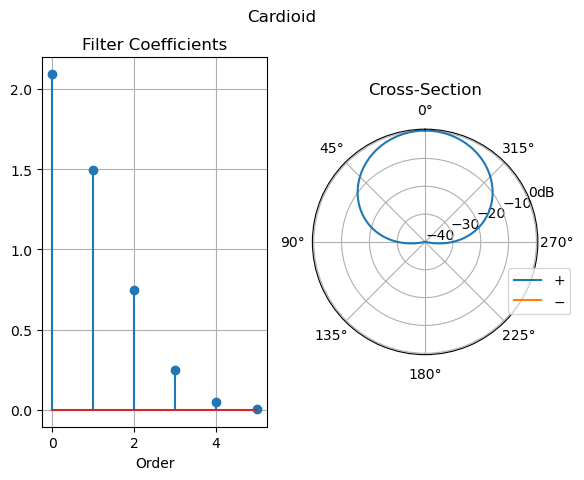

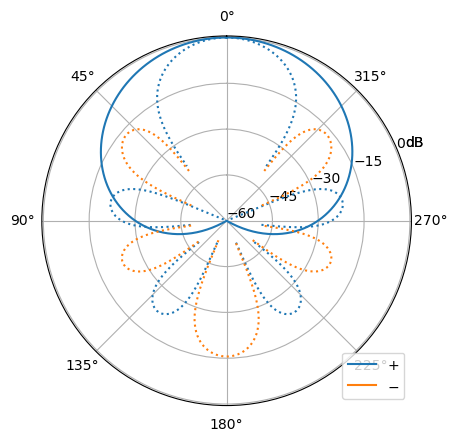

In [7]:
#Cardioid

w_n = spa.sph.cardioid_modal_weights(N_sph)
w_n = spa.sph.unity_gain(w_n)

plot_sph_filter(w_n, title="Cardioid")
polar_comparison(w_n, rlim=[-60, 0])


The $\operatorname{max}r_E$ window is well established in spatial audio.
It corresponds roughly to a (higher-order) super-cardioid.

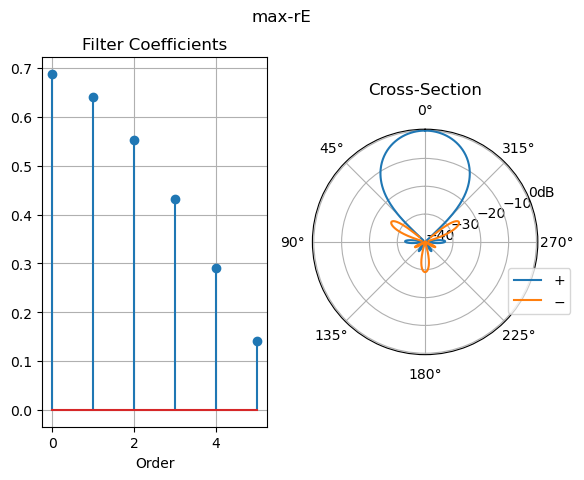

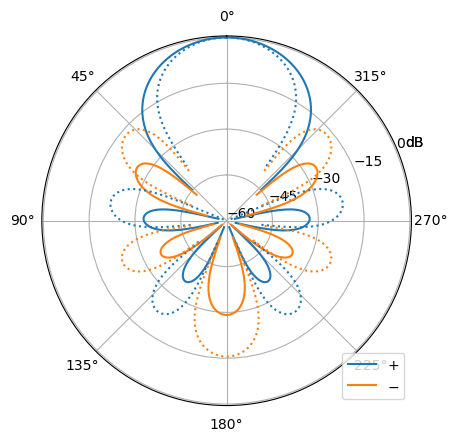

In [8]:
#maxrE

w_n = spa.sph.maxre_modal_weights(N_sph)
w_n = spa.sph.unity_gain(w_n)

plot_sph_filter(w_n, title="max-rE")
polar_comparison(w_n, rlim=[-60, 0])


Next, some implementations of classic literature SH filters / tapering windows are presented.

The Butterworth filter is widely applied in signal processing literature, and it is caracterized by its filter order $k$.

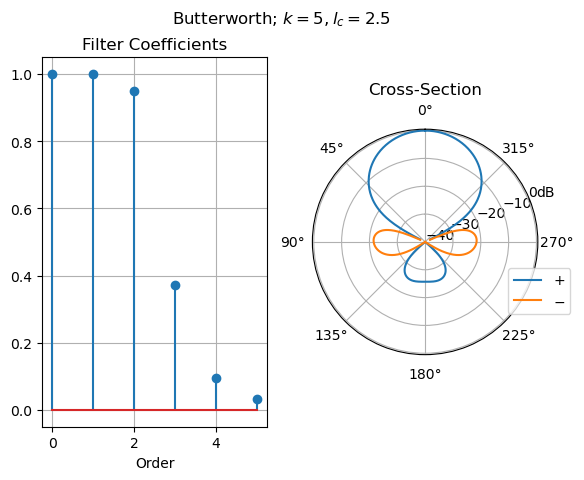

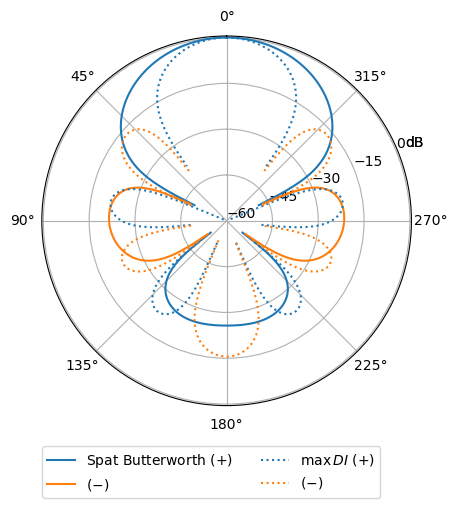

In [9]:
#Butterworth
l_c = (N_sph)//2 + 0.5 # tuning parameter
k = 5
w_n = 1/np.sqrt(1+(np.arange(N_sph+1) / l_c)**(2*k))

w_n = spa.sph.unity_gain(w_n)

plot_sph_filter(w_n, title=f"Butterworth; $k={k}, l_c={l_c}$")
polar_comparison(w_n, rlim=[-60, 0])
plt.legend(['Spat Butterworth $(+)$', '$(-)$', '$\operatorname{max}DI$ $(+)$', '$(-)$'], loc=(0,-0.25),ncol=2)
#plt.gcf().set_size_inches(3.3, 3.)
plt.savefig('SpatButterworthPolar.pdf', bbox_inches='tight')


Previously, the half-sided Hann window showed good results.

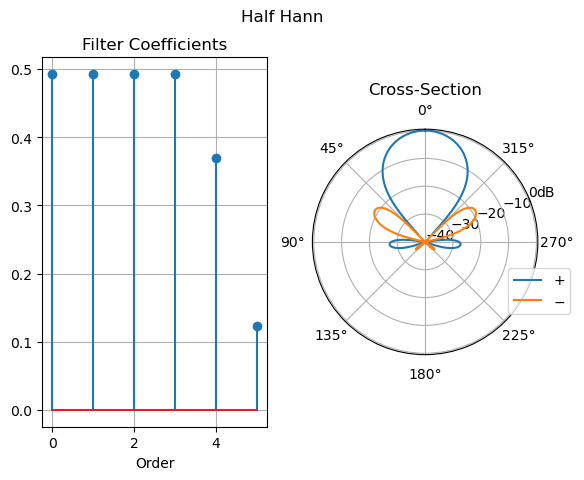

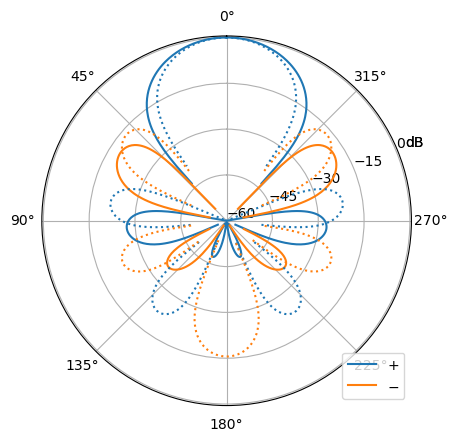

In [10]:
# Half Hann
w_n = spa.process.half_sided_Hann(N_sph)

w_n = spa.sph.unity_gain(w_n)

plot_sph_filter(w_n, title=f"Half Hann")
polar_comparison(w_n, rlim=[-60, 0])


The more general class of these filters are based on the spectral cosine window.
For $k=2$, they become the Hann window.
These show a great parameterization flexibility, where not only the order, but also the slope and cutoff order can be explicitly specified.


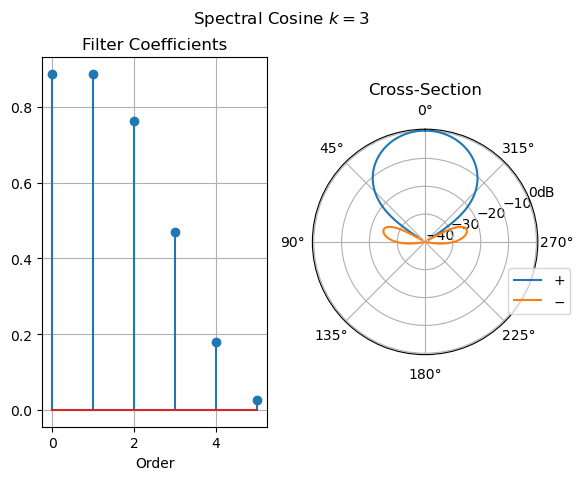

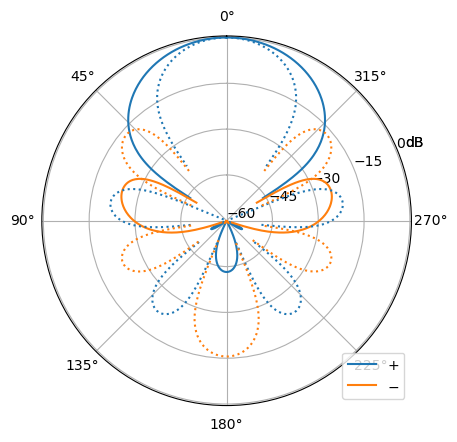

In [11]:
#Spectral Cosine
l_s = 1
l_c = N_sph+1
k = (N_sph+1)//2

w_n = np.ones(N_sph+1)
w_n[l_s:l_c] = np.cos(np.pi/2 * (np.arange(l_s, l_c) - l_s) / (l_c - l_s) ) **k
w_n[l_c:] = 0

w_n = spa.sph.unity_gain(w_n)

plot_sph_filter(w_n, title=f"Spectral Cosine $k={k}$")
polar_comparison(w_n, rlim=[-60, 0])


The diffusion filter is another interesting example, which had very desirable properties 

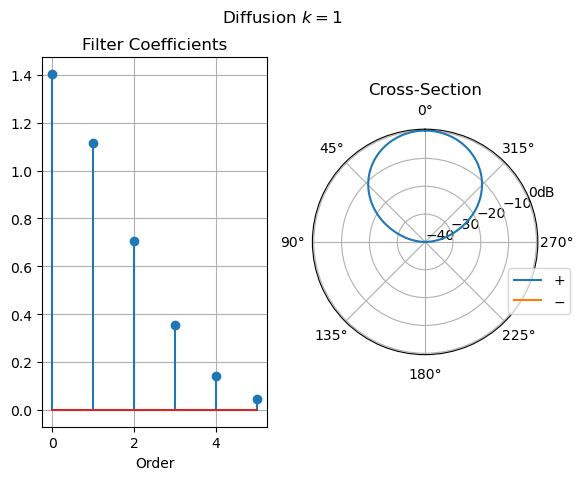

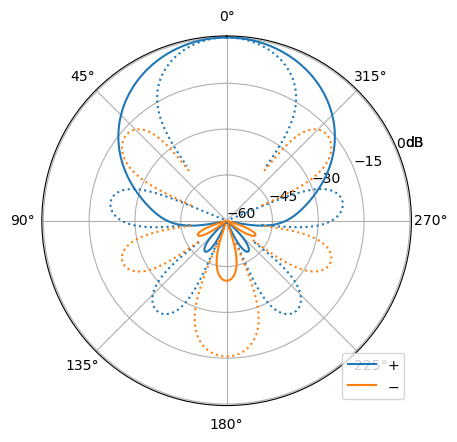

In [12]:
## Diffusion
l_c = N_sph / 2
k = 1

w_n = np.exp(- ( (np.arange(N_sph+1) * (np.arange(N_sph+1)+1)) / (l_c * (l_c+1)) )**k)

w_n = spa.sph.unity_gain(w_n)

plot_sph_filter(w_n, title=f"Diffusion $k={k}$")
polar_comparison(w_n, rlim=[-60, 0])


The Gaussian smoothing window is specified in the space domain, and derives the according coefficients.
It specifies an opening angle, and portion to drop at that angle.

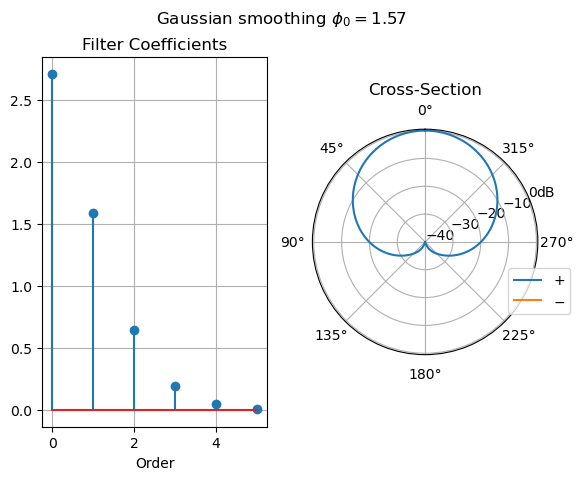

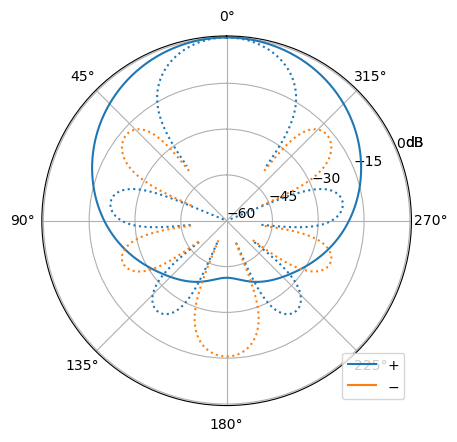

In [13]:
# Gaussian Kernel
phi0=np.deg2rad(90)
n_g = spa.utils.from_db(20) # fraction to drop
a = np.log(n_g) / (1-np.cos(phi0))
# recursive solution
w_n = np.zeros(N_sph+1)
for l in range(N_sph+1):
    if l==0:
        w_n[l] = 1
    if l==1:
        w_n[l] = np.cosh(a)/np.sinh(a) - 1/a
    if l>1:
        w_n[l] = -(2*(l-1)+1)/a * w_n[l-1] + w_n[l-2]

w_n = spa.sph.unity_gain(w_n)

plot_sph_filter(w_n, title=f"Gaussian smoothing $\phi_0={np.round(phi0,2)}$")
polar_comparison(w_n, rlim=[-60, 0])


The Pellinen filter has a slightly different design strategy.
Here, the filter is specified by an opening angle.

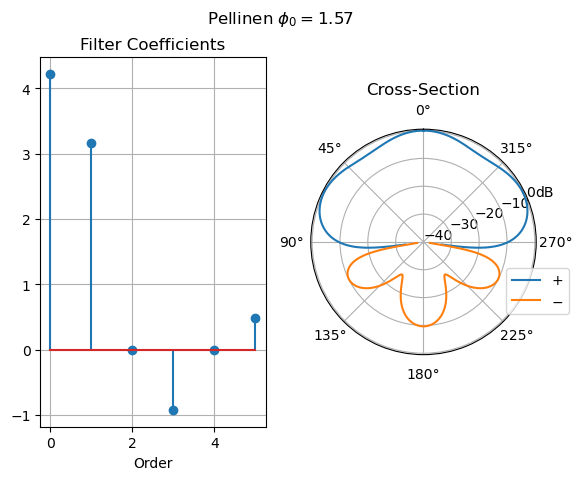

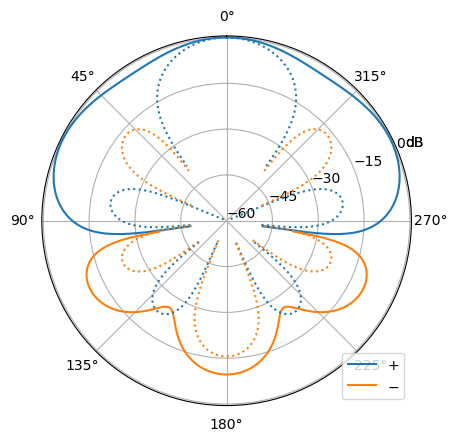

In [14]:
# Pellinen
from scipy.special import eval_legendre

phi0 = spa.utils.deg2rad(90)
w_n = 1/(np.arange(N_sph+1) + 1) * ( 
    (eval_legendre(np.arange(N_sph+1) - 1, np.cos(phi0)) - eval_legendre(np.arange(N_sph+1) + 1, np.cos(phi0))) / (1-np.cos(phi0)) )

w_n = spa.sph.unity_gain(w_n)

plot_sph_filter(w_n, title=f"Pellinen $\phi_0={np.round(phi0,2)}$")
polar_comparison(w_n, rlim=[-60, 0])


The Polynomial structure of the Butterworth filter gave opportunity to further shapes as the experiment below.

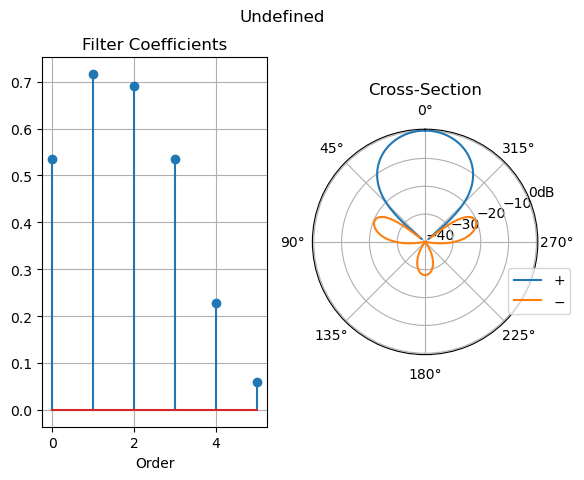

In [15]:
#whats this then
l_c = 3
w_n = 1/np.sqrt(1+(np.arange(N_sph+1) / l_c)**(2*np.arange(N_sph+1)))

w_n = spa.sph.unity_gain(w_n)

plot_sph_filter(w_n, title="Undefined")

In [16]:
#%%capture
# Create Static --execute
#!jupyter-nbconvert --to pdf SH-filters.ipynb --TagRemovePreprocessor.remove_input_tags hide_input